In [460]:
import pandas as pd
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from catboost import CatBoostRegressor

In [45]:
#loading initial dataset
data = pd.read_csv('data/03april2018_full.csv')

In [46]:
#taking mean from 4 sensors
measures = np.array(data['frame_type'])>0
data_meas = data.iloc[measures,:]
data_meas = data_meas[data_meas['value'].str.contains('Start') == False]
data_meas['value'] = data_meas['value'].astype(float)
data_meas = pd.pivot_table(data_meas, values='value',index='timestamp', columns='sensor', aggfunc='mean')
data_meas.index = pd.to_datetime(data_meas.index)
data_meas = data_meas.drop_duplicates()
arr = np.array(data_meas.index, dtype='datetime64[s]').view('i8')
dates = np.mean(arr.reshape(-1, 4), axis=1).astype('datetime64[s]')
meas = data_meas.groupby(np.arange(len(data_meas))//4).mean()
meas['timestamp'] = dates
data_meas = meas.set_index(['timestamp'])
data_meas = data_meas.drop(columns=['BAT'])

In [50]:
#preprocessing whole data_cond
data_cond = data.iloc[measures!=True,:]
data_cond = pd.pivot_table(data_cond, values='value',index='timestamp', columns='sensor', aggfunc='first')
data_cond.fillna(value=np.nan, inplace=True)
cols_float = ['air_cond_HC', 'air_cond_state', 'air_in_val1_PV', 'air_in_val1_SP',
              'air_in_val2_PV', 'air_in_val2_SP', 'air_out_val1_PV',
              'air_out_val1_SP', 'air_out_val2_PV', 'air_out_val2_SP',
              'people_number', 'radiator_HC_1', 'radiator_HC_2']
data_cond[cols_float] = data_cond[cols_float].astype(float)
cols_comma = ['PVT_air_in_H', 'PVT_air_in_T', 'PVT_air_out_H', 'PVT_air_out_T', 'air_in_speed']
for col in cols_comma:
    data_cond[col] = data_cond[col][pd.notnull(data_cond[col])].apply(lambda x: x.replace(',','.'))
    data_cond[col] = data_cond[col].astype(float)
data_cond['door_state'] = data_cond['door_state'].replace(to_replace='CLOSE', value=1)
data_cond['door_state'] = data_cond['door_state'].replace(to_replace='OPEN', value=0)
cols_val = ['radiator_val1', 'radiator_val2', 'radiator_val3']
for col in cols_val:
    data_cond[col] = data_cond[col].replace(to_replace='FALSE', value=0) #closed
    data_cond[col] = data_cond[col].replace(to_replace='TRUE', value=1) #opened
data_cond = data_cond.drop(columns=['aaaaaaaaaaaaaaa','aaaaaaaaaaaaaaaa', 'air_cond_HC',
                      'radiator_HC_1', 'radiator_HC_2', 'air_out_speed'])
data_cond.index = pd.to_datetime(data_cond.index)

In [525]:
#merging datasets
data = data_meas.merge(data_cond.dropna(), left_index=True, right_index=True, how='outer')

In [526]:
#outside weather
#downloaded from https://rp5.ru/ for Moscow region
weather_data = pd.read_csv('data/weather_dataset.csv', header=6, delimiter=';')
weather_data = pd.DataFrame(weather_data.iloc[:,0])
weather_data.index = pd.DataFrame(weather_data.index).loc[:,0].apply(lambda x: str(x[3:6]+x[0:3]+x[6:]))
weather_data.index = pd.to_datetime(weather_data.index)
weather_data.columns = ['T_out']
data = weather_data.merge(data, left_index=True, right_index=True, how='outer')

In [527]:
#interpolation
data = data.resample('T').mean().interpolate(method='linear') #method='cubic'
data = data.dropna()
data = data['2018-01-26 17:31:00':'2018-04-03 16:36:00']

In [528]:
# Power consumption
S = np.pi*0.25**2
ro = 1.2754
Cp = 1000
Q = S * ro * data['air_in_speed']
P_vent = (Cp*Q*np.abs(data['T_out']-data['PVT_air_in_T'])+ Q*data['air_in_speed']**2/2)/1000
P_rad = data[['radiator_val1','radiator_val2','radiator_val3']].sum(axis=1)*0.3
P_fan = data['air_cond_state']*3
P_total = P_vent + P_rad + P_fan
data['P_total'] = P_total

In [529]:
data['radiator'] = deepcopy(data[['radiator_val1', 'radiator_val2', 'radiator_val3']].sum(axis=1))
data['air_in_val'] = deepcopy(data[['air_in_val1_PV', 'air_in_val2_PV']].sum(axis=1))

In [530]:
data['deltaT'] = deepcopy(data['PVT_air_out_T']-data['PVT_air_in_T'])

In [531]:
data = data.drop(columns=['radiator_val1', 'radiator_val2', 'radiator_val3',
                          'air_out_val1_PV', 'air_out_val1_SP', 'air_out_val2_PV',
                          'air_out_val2_SP', 'air_in_val1_SP', 'air_in_val2_SP',
                          'air_in_val1_PV', 'air_in_val2_PV'])

## $\Delta T$ offset dataset

In [560]:
offset = 10

In [561]:
x_t = data[['CO2', 'HUM', 'PRES', 'deltaT', 'PVT_air_in_H','PVT_air_out_H', 'air_cond_state', 'air_in_speed',
       'door_state', 'people_number', 'P_total', 'radiator', 'air_in_val']][:-offset]
data_offset = deepcopy(data['TC'])
data_offset.index = data_offset.index - np.timedelta64(offset, 'm')
y_t = deepcopy(data_offset-data['TC'])[offset:-offset]

In [562]:
x_train, x_test, y_train, y_test = train_test_split(x_t, y_t, test_size=0.2, shuffle=False)
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()
x_train = scale_x.fit_transform(x_train)
y_train = scale_y.fit_transform(y_train.values.reshape(-1,1))
x_test = scale_x.transform(x_test)
y_test = scale_y.transform(y_test.values.reshape(-1,1))

### Catboost: model $\Delta T$

In [563]:
cat = CatBoostRegressor()
cat.fit(x_train, np.ravel(y_train), verbose=False)
y_pred = cat.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_pred)))
print(np.sqrt(mean_squared_error(y_test, y_pred))/np.mean(np.abs(y_test)))

0.04411484146509947
0.07120216396792078


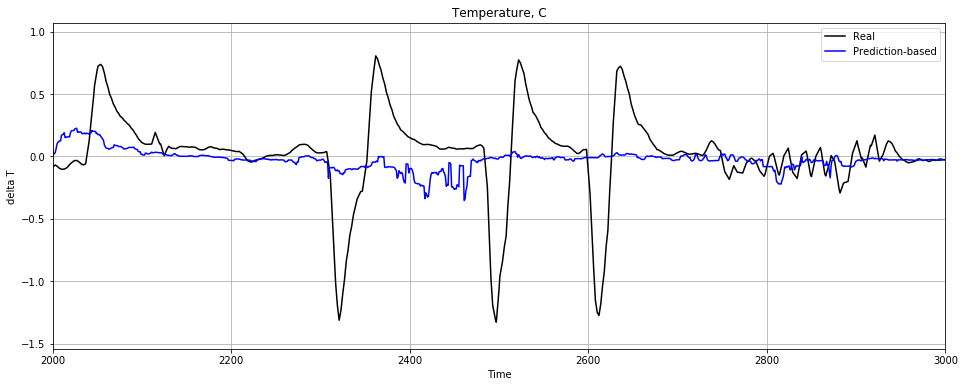

In [568]:
plt.figure(figsize=(16,6))
plt.plot(scale_y.inverse_transform(y_test), 'k', label='Real')
plt.plot(scale_y.inverse_transform(y_pred.reshape(-1,1)), 'b', label='Prediction-based')
plt.legend()
plt.title('Temperature, C')
plt.xlabel('Time')
plt.ylabel('delta T')
#plt.ylim([0,1])
plt.xlim([2000,3000])
plt.grid()
plt.show()

## Support Vector Machine: model $\Delta T$

In [537]:
svr = SVR(kernel='rbf')
svr.fit(x_train, np.ravel(y_train))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [538]:
svr_pred = svr.predict(x_test)

In [539]:
print(np.sqrt(mean_squared_error(y_test, svr_pred))/np.mean(np.abs(y_test)))

0.08051000631369729


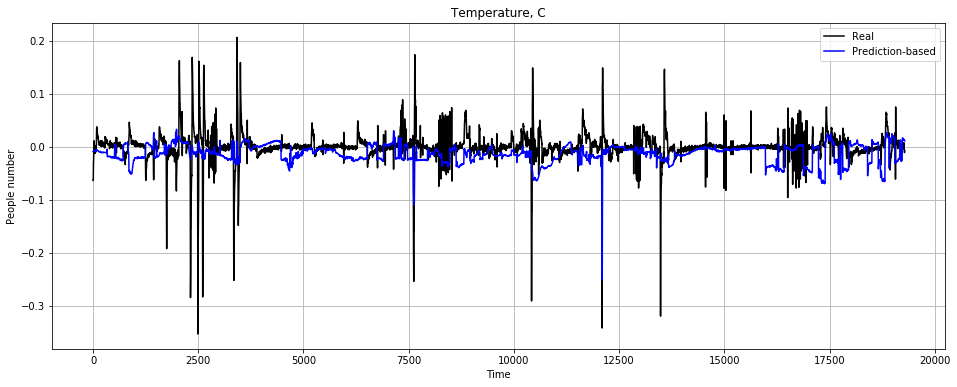

In [540]:
plt.figure(figsize=(16,6))
plt.plot(scale_y.inverse_transform(y_test), 'k', label='Real')
plt.plot(scale_y.inverse_transform(svr_pred.reshape(-1,1)), 'b', label='Prediction-based')
plt.legend()
plt.title('Temperature, C')
plt.xlabel('Time')
plt.ylabel('People number')
#plt.ylim([0,1])
#plt.xlim([0,100])
plt.grid()
plt.show()

## Sensitivity analysis: model $\Delta T$

In [541]:
from SALib.analyze import sobol as sobol_analyzer
from SALib.analyze import morris as morris_analyzer

from SALib.sample import saltelli as saltelli_sampler
from SALib.sample import morris as morris_sampler

In [542]:
bounds = np.hstack((np.array(x_train.min()).reshape(-1,1),np.array(x_train.max()).reshape(-1,1)))

In [543]:
problem = {
    'num_vars': 13,
    #'names': features_cols,
    'bounds': bounds,
    'groups': None
    }

In [544]:
x_sat = saltelli_sampler.sample(problem, 250)
y1, y2, y3 = np.zeros(x_sat.shape[0]), np.zeros(x_sat.shape[0]), np.zeros(x_sat.shape[0])

for i, xi in enumerate(x_sat):
    xi = xi.reshape(1, -1)
    y1[i] = cat.predict(xi)
    y2[i] = svr.predict(xi)
    
sobol_1 = sobol_analyzer.analyze(problem, y1, conf_level=0.97)
sobol_2 = sobol_analyzer.analyze(problem, y2, conf_level=0.97)

<BarContainer object of 13 artists>

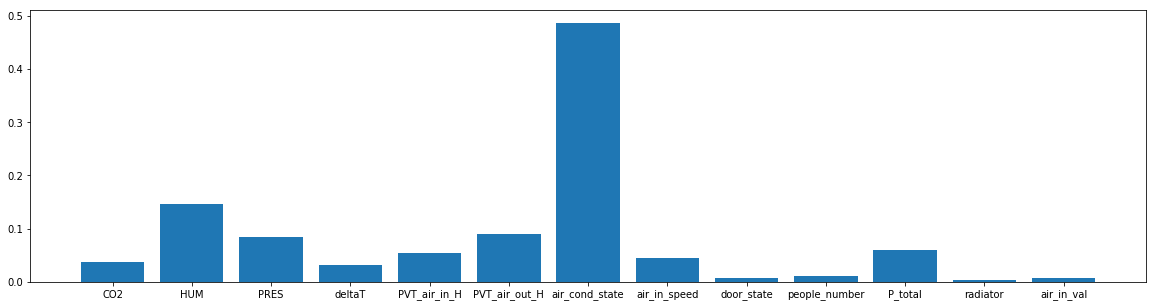

In [545]:
plt.figure(figsize=(20,5))
plt.bar(x_t.columns.values, sobol_1['ST'])

<BarContainer object of 13 artists>

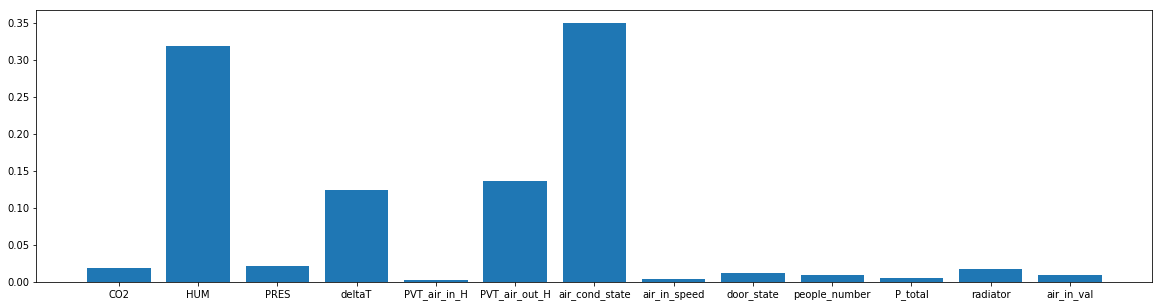

In [546]:
plt.figure(figsize=(20,5))
plt.bar(x_t.columns.values, sobol_2['ST'])

## $CO_2$ model dataset

In [547]:
offset = 8

In [548]:
x_co = data[['TC', 'HUM', 'PRES', 'deltaT', 'PVT_air_in_H','PVT_air_out_H', 'air_cond_state', 'air_in_speed',
       'door_state', 'people_number', 'P_total', 'radiator', 'air_in_val']][:-offset]
data_offset = deepcopy(data['CO2'])
data_offset.index = data_offset.index - np.timedelta64(offset, 'm')
y_co = deepcopy(data_offset-data['CO2'])[offset:-offset]

In [549]:
x_train, x_test, y_train, y_test = train_test_split(x_co, y_co, test_size=0.2, shuffle=False)
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()
x_train = scale_x.fit_transform(x_train)
y_train = scale_y.fit_transform(y_train.values.reshape(-1,1))
x_test = scale_x.transform(x_test)
y_test = scale_y.transform(y_test.values.reshape(-1,1))

### Catboost: model $CO_2$

In [550]:
cat = CatBoostRegressor()
cat.fit(x_train, np.ravel(y_train), verbose=False)
y_pred = cat.predict(x_test)
print(np.sqrt(mean_squared_error(y_test, y_pred))/np.mean(np.abs(y_test)))

0.09610456521609625


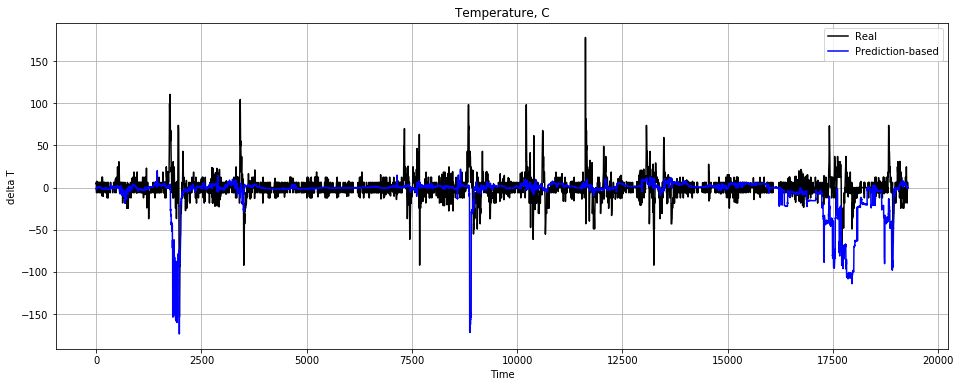

In [551]:
plt.figure(figsize=(16,6))
plt.plot(scale_y.inverse_transform(y_test), 'k', label='Real')
plt.plot(scale_y.inverse_transform(y_pred.reshape(-1,1)), 'b', label='Prediction-based')
plt.legend()
plt.title('Temperature, C')
plt.xlabel('Time')
plt.ylabel('delta T')
#plt.ylim([0,1])
#plt.xlim([0,100])
plt.grid()
plt.show()